In [33]:
import numpy as np
import pandas as pd

! pip install transformers
! pip install sacremoses

In [34]:
from typing import Callable, List, Optional, Tuple
import pandas as pd
from sklearn.base import TransformerMixin, BaseEstimator
import torch

class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(
            self,
            bert_tokenizer,
            bert_model,
            max_length: int = 60,
            embedding_func: Optional[Callable[[torch.tensor], torch.tensor]] = None,
    ):
        self.bert_tokenizer = bert_tokenizer
        self.bert_model = bert_model
        self.bert_model.eval()
        self.max_length = max_length
        self.embedding_func = embedding_func

        if self.embedding_func is None:
            self.embedding_func = lambda x: x[0][:, 0, :].squeeze()

    def _tokenize(self, text: str) -> Tuple[torch.tensor, torch.tensor]:
        tokenized_text = self.bert_tokenizer.encode_plus(text,
                                                         add_special_tokens=True,
                                                         max_length=self.max_length
                                                         )["input_ids"]

        attention_mask = [1] * len(tokenized_text)

        return (
            torch.tensor(tokenized_text).unsqueeze(0),
            torch.tensor(attention_mask).unsqueeze(0),
        )

    def _tokenize_and_predict(self, text: str) -> torch.tensor:
        tokenized, attention_mask = self._tokenize(text)

        embeddings = self.bert_model(tokenized, attention_mask)
        return self.embedding_func(embeddings)

    def transform(self, text: List[str]):
        if isinstance(text, pd.Series):
            text = text.tolist()

        with torch.no_grad():
            return torch.stack([self._tokenize_and_predict(string) for string in text])

    def fit(self, X, y=None):
        return self


In [35]:
from transformers import AutoTokenizer, AutoModel

model_names = {
    "herbert-klej-cased-v1": {
        "tokenizer": "allegro/herbert-klej-cased-tokenizer-v1",
        "model": "allegro/herbert-klej-cased-v1",
    },
    "herbert-base-cased": {
        "tokenizer": "allegro/herbert-base-cased",
        "model": "allegro/herbert-base-cased",
    },
    "herbert-large-cased": {
        "tokenizer": "allegro/herbert-large-cased",
        "model": "allegro/herbert-large-cased",
    },
}

tokenizer = AutoTokenizer.from_pretrained(model_names["herbert-base-cased"]["tokenizer"])
bert_model = AutoModel.from_pretrained(model_names["herbert-base-cased"]["model"]) 
bert_transformer = BertTransformer(tokenizer, bert_model)

Some weights of the model checkpoint at allegro/herbert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.sso.sso_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.sso.sso_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [36]:
file_name = 'GDT_data_v01.xlsx'
df = pd.read_excel(io=file_name)

In [37]:
df['nlp_2_4_5'] = df['nlp_4'] + df['nlp_5'] + df['nlp_2']
df['sex'] = [(male, female) for male, female in zip(df['is_male'], df['is_female'])]

In [38]:
X_1_COLUMN = 'nlp_2_4_5'
X_2_COLUMN = 'age'
X_3_COLUMN = 'sex'
Y_COLUMN = 'GDT_score'

In [39]:
from sklearn.model_selection import train_test_split

cleaned_df = df[~df[X_1_COLUMN].isna()]
working_df = cleaned_df.filter([X_2_COLUMN, X_1_COLUMN, X_3_COLUMN, Y_COLUMN])
df_train, df_test = train_test_split(working_df, test_size = 0.2, random_state=23)

In [40]:
X_train = df_train.drop(Y_COLUMN, axis=1)
Y_train = df_train[Y_COLUMN].values

X_test = df_test.drop(Y_COLUMN, axis=1)
Y_test = df_test[Y_COLUMN].values

In [41]:
X_train[X_2_COLUMN].values.shape

(377,)

In [42]:
tokenized_train_x = bert_transformer.transform(X_train[X_1_COLUMN])
reshaped_x_2 = [[item] for item in X_train[X_2_COLUMN]]
reshaped_x_3 = [item for item in X_train[X_3_COLUMN]]

all_train_x = np.hstack((tokenized_train_x, reshaped_x_2, reshaped_x_3))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [43]:
tokenized_test_x = bert_transformer.transform(X_test[X_1_COLUMN])
reshaped_x_2_test = [[item] for item in X_test[X_2_COLUMN]]
reshaped_x_3_test = [item for item in X_test[X_3_COLUMN]]

all_test_x = np.hstack((tokenized_test_x, reshaped_x_2_test, reshaped_x_3_test))

In [293]:
from sklearn import svm
vector_regression = svm.SVR(kernel='linear', C=2.2, tol=1e-3)
vector_regression.fit(all_train_x, Y_train)

SVR(C=2.2, kernel='linear')

In [294]:
result = vector_regression.predict(all_test_x)

In [295]:
from scipy import stats
result = [item if item >= 4 else 4 for item in result]
print(stats.pearsonr(result, Y_test))

PearsonRResult(statistic=0.5706602208369147, pvalue=1.5639459387083056e-09)


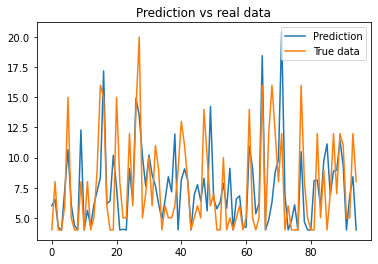

In [296]:
import matplotlib.pyplot as plt

plt.plot(range(len(result)), result, label="Prediction")
plt.plot(range(len(Y_test)), Y_test, label='True data')
plt.legend(loc='upper right')
plt.title('Prediction vs real data')
plt.show()